## Importing Requried Libraries

In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D

Using TensorFlow backend.


## Preprocessing 

In [2]:
# assigning path to the images
path = 'Digit_Data'
# Creating empty list for storing all the images
images = []
# Storing class labels
classNo = []

myList = os.listdir(path) 
print(myList)
print('Total Classes: ', len(myList))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total Classes:  10


In [3]:
noOfClasses = len(myList)

# Iterating all over the data folder 
for x in range(0, noOfClasses):
    # listing all the labels(0,1....)
    myPicList = os.listdir(path + '/' + str(x))
    for y in myPicList:
        # Iterating over the images
        curImg = cv2.imread(path + '/' + str(x) + '/' + y)
        curImg = cv2.resize(curImg, (32,32))
        images.append(curImg)
        classNo.append(x)
    print(x, end = ' ')
print(' ')
print('Total Images: ',len(images))

Total Classes:  10
0 1 2 3 4 5 6 7 8 9  
Total Images:  10160


In [4]:
# We can't send direct images to our model
images = np.array(images)
classNo = np.array(classNo)

print(images.shape)
print(classNo.shape)

(10160, 32, 32, 3)
(10160,)


## Splitting 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_valid.shape, y_valid.shape

((6502, 32, 32, 3),
 (2032, 32, 32, 3),
 (6502,),
 (2032,),
 (1626, 32, 32, 3),
 (1626,))

## Visualization

In [6]:
numOfSamples = []
for i in range(0, noOfClasses):
    #print(f'Total {i} : ', len(np.where(y_train==i)[0]))
    numOfSamples.append(len(np.where(y_train==i)[0]))
    
print(numOfSamples)

[644, 651, 653, 649, 661, 657, 651, 633, 667, 636]


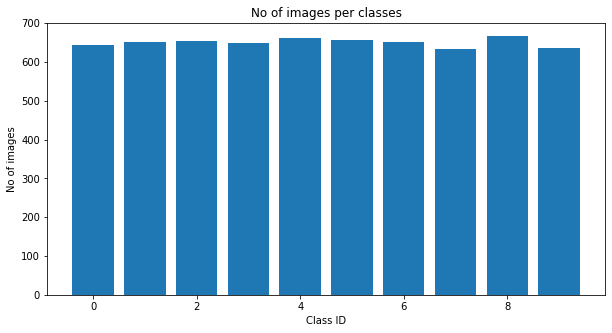

In [7]:
plt.figure(figsize=(10,5))
plt.bar(range(0, noOfClasses), numOfSamples)
plt.title('No of images per classes')
plt.xlabel('Class ID')
plt.ylabel('No of images')
plt.show()

In [8]:
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img

In [9]:
## Seing our preprocessed image v/s real image
img = preProcessing(X_train[30])
img = cv2.resize(img, (300,300))
cv2.imshow('Pre Processed Image', img)
cv2.imshow('Actual Image', X_train[30])
cv2.waitKey(0)


In [10]:
# Mapping our preprocessing function to all images

X_train = np.array(list(map(preProcessing, X_train)))
X_test  = np.array(list(map(preProcessing, X_test)))
X_valid = np.array(list(map(preProcessing, X_valid)))

In [11]:
# We only have only two channels
X_train.shape, X_test.shape, X_valid.shape

((6502, 32, 32), (2032, 32, 32), (1626, 32, 32))

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)

In [13]:
X_train.shape, X_test.shape, X_valid.shape

((6502, 32, 32, 1), (2032, 32, 32, 1), (1626, 32, 32, 1))

## Data Augmentation
- to save ourself from overfitting

In [14]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)

In [15]:
dataGen.fit(X_train)

In [16]:
y_train = to_categorical(y_train, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)
y_valid = to_categorical(y_valid, noOfClasses)

## Model Creation

In [17]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3,3)
    sizeOfPool = (2,2)
    noOfNode = 500
    
    model = Sequential()
    model.add(Conv2D(noOfFilters, sizeOfFilter1, input_shape=(32,32,1), activation='relu'))
    model.add(Conv2D(noOfFilters, sizeOfFilter1, activation='relu'))
    model.add(MaxPooling2D(sizeOfPool))
    model.add(Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu'))
    model.add(Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu'))
    model.add(MaxPooling2D(sizeOfPool))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(noOfNode, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(noOfClasses, activation='softmax'))
    
    model.compile(Adam(lr=0.001),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

model = myModel()

In [18]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [19]:
history = model.fit_generator(dataGen.flow(X_train, y_train, batch_size=50), epochs=2,
                                           steps_per_epoch=2000, validation_data=(X_valid, y_valid),
                                           shuffle=1)

Epoch 1/2
2000/2000 [==============================] - 1549s 775ms/step - loss: 0.2239 - accuracy: 0.9267 - val_loss: 0.0177 - val_accuracy: 0.9938
Epoch 2/2
2000/2000 [==============================] - 1679s 839ms/step - loss: 0.0711 - accuracy: 0.9776 - val_loss: 0.0167 - val_accuracy: 0.9957


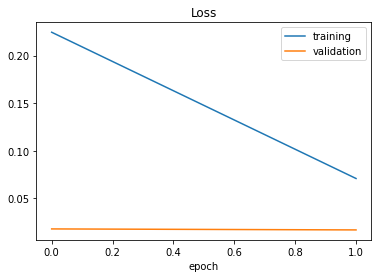

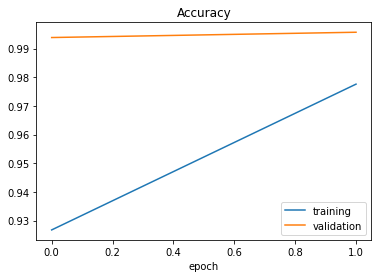

In [20]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [21]:
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.01420692631274226
Test Accuracy = 0.9945865869522095


In [24]:
pickle_out= open("model_trained.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()